<a href="https://colab.research.google.com/github/saipragna25/deep-learning-asgn-neural-networks-/blob/main/DL_NN_with_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

using low level API

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
# Define the non-linear equation to generate synthetic data
def non_linear_eqn(x, y, z):
    return jnp.sin(x) * jnp.cos(y) + 2 * jnp.sin(z)

In [ ]:
# Generate synthetic data
key = random.PRNGKey(0)
num_samples = 500
x = random.uniform(key, (num_samples,)) * 2 * jnp.pi
y = random.uniform(key, (num_samples,)) * 2 * jnp.pi
z = random.uniform(key, (num_samples,)) * 2 * jnp.pi
noise = random.normal(key, (num_samples,)) * 0.1
labels = non_linear_eqn(x, y, z) + noise

In [ ]:
# Define the neural network architecture
def init_network_params(layer_sizes, key):
    params = []
    for i in range(1, len(layer_sizes)):
        input_size, output_size = layer_sizes[i-1], layer_sizes[i]
        k1, k2 = random.split(key)
        weight = random.normal(k1, (input_size, output_size))
        bias = random.normal(k2, (output_size,))
        params.append((weight, bias))
    return params

In [ ]:
def relu(x):
    return jnp.maximum(0, x)


def predict(params, inputs):
    for w, b in params[:-1]:
        outputs = jnp.einsum('...i,ij->...j', inputs, w) + b
        inputs = relu(outputs)
    final_w, final_b = params[-1]
    return jnp.einsum('...i,ij->...j', inputs, final_w) + final_b

In [ ]:
# Define the loss function and accuracy metric
def mse_loss(params, inputs, targets):
    preds = predict(params, inputs)
    return jnp.mean(jnp.square(preds - targets))

def accuracy(params, inputs, targets):
    preds = predict(params, inputs)
    return jnp.mean(jnp.abs(preds - targets))

In [ ]:
#Define the training loop
@jit
def update(params, inputs, targets, lr):
    grads = grad(mse_loss)(params, inputs, targets)
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]


def train(layer_sizes, inputs, targets, lr, num_epochs):
    params = init_network_params(layer_sizes, random.PRNGKey(0))
    for i in range(num_epochs):
        params = update(params, inputs, targets, lr)
        if i % 100 == 0:
            print(f"Loss at epoch {i}: {mse_loss(params, inputs, targets)}")
    return params

In [ ]:
# Train the model
layer_sizes = [3, 16, 8, 1]
lr = 0.01
num_epochs = 1000
trained_params = train(layer_sizes, jnp.stack([x, y, z], axis=-1), labels, lr, num_epochs)

Loss at epoch 0: 18336.87890625
Loss at epoch 100: 18746628.0
Loss at epoch 200: 329716.6875
Loss at epoch 300: 5800.9306640625
Loss at epoch 400: 103.91578674316406
Loss at epoch 500: 3.716944456100464
Loss at epoch 600: 1.9546524286270142
Loss at epoch 700: 1.9236584901809692
Loss at epoch 800: 1.9231113195419312
Loss at epoch 900: 1.9231023788452148


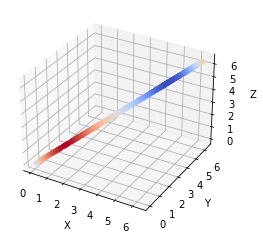

In [ ]:
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=labels, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Using High-Level API

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from jax.example_libraries import optimizers as jax_opt

In [ ]:
# Define the non-linear equation to generate synthetic data
def non_linear_eqn(x, y, z):
    return jnp.sin(x) * jnp.cos(y) + 2 * jnp.sin(z)

In [ ]:
# Generate synthetic data
key = random.PRNGKey(0)
num_samples = 500
x = random.uniform(key, (num_samples,)) * 2 * jnp.pi
y = random.uniform(key, (num_samples,)) * 2 * jnp.pi
z = random.uniform(key, (num_samples,)) * 2 * jnp.pi
noise = random.normal(key, (num_samples,)) * 0.1
labels = non_linear_eqn(x, y, z) + noise

In [ ]:
# Define the neural network architecture
layer_sizes = [3, 16, 8, 1]

def relu(x):
    return jnp.maximum(0, x)


def init_params(layer_sizes, key):
    params = []
    for i in range(1, len(layer_sizes)):
        input_size, output_size = layer_sizes[i-1], layer_sizes[i]
        k1, k2 = random.split(key)
        weight = random.normal(k1, (input_size, output_size))
        bias = random.normal(k2, (output_size,))
        params.append((weight, bias))
    return params


def predict(params, inputs):
    for w, b in params[:-1]:
        outputs = jnp.einsum('...i,ij->...j', inputs, w) + b
        inputs = relu(outputs)
    final_w, final_b = params[-1]
    return jnp.einsum('...i,ij->...j', inputs, final_w) + final_b


In [ ]:
# Define the loss function and accuracy metric
def mse_loss(params, inputs, targets):
    preds = predict(params, inputs)
    return jnp.mean(jnp.square(preds - targets))


def accuracy(params, inputs, targets):
    preds = predict(params, inputs)
    return jnp.mean(jnp.abs(preds - targets))

In [ ]:
# Define the training loop
@jax.jit
def update(params, inputs, targets, lr):
    grads = grad(mse_loss)(params, inputs, targets)
    return jax.tree_multimap(lambda param, grad: param - lr * grad, params, grads)

In [ ]:
def train(layer_sizes, inputs, targets, lr, num_epochs):
    params = init_params(layer_sizes, random.PRNGKey(0))
    opt_init, opt_update, get_params = jax_opt.adam(lr)
    opt_state = opt_init(params)
    for i in range(num_epochs):
        params = get_params(opt_state)
        opt_state = opt_update(i, grad(mse_loss)(params, inputs, targets), opt_state)
        if i % 100 == 0:
            print(f"Loss at epoch {i}: {mse_loss(params, inputs, targets)}")
    return params

In [ ]:
# Train the model
lr = 0.01
num_epochs = 1000
trained_params = train(layer_sizes, jnp.stack([x, y, z], axis=-1), labels, lr, num_epochs)

Loss at epoch 0: 13.704989433288574
Loss at epoch 100: 1.9350706338882446
Loss at epoch 200: 1.9238325357437134
Loss at epoch 300: 1.9237982034683228
Loss at epoch 400: 1.9237606525421143
Loss at epoch 500: 1.9237239360809326
Loss at epoch 600: 1.9236878156661987
Loss at epoch 700: 1.9236438274383545
Loss at epoch 800: 1.9235951900482178
Loss at epoch 900: 1.9235576391220093


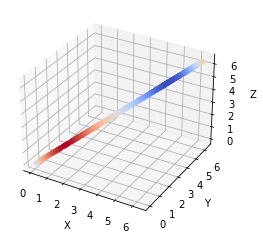

In [ ]:
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=labels, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()